In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

In [2]:
fibroblast = sc.read_h5ad("/mnt/c/Users/ouyangkang/Downloads/firbroblast_GSE203115.h5ad")

In [3]:
fibroblast

AnnData object with n_obs × n_vars = 1248 × 16948
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'n_genes', 'patients', 'response', 'T cells', 'B cells', 'Myeloid cells', 'Fibroblasts', 'Pericytes', 'Endotheial', 'Epithelial', 'leiden', 'anno', 'sub_anno'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'hsp', 'n_cells_by_counts-ESCC_1', 'mean_counts-ESCC_1', 'pct_dropout_by_counts-ESCC_1', 'total_counts-ESCC_1', 'n_cells_by_counts-ESCC_2', 'mean_counts-ESCC_2', 'pct_dropout_by_counts-ESCC_2', 'total_counts-ESCC_2', 'n_cells_by_counts-ESCC_3', 'mean_counts-ESCC_3', 'pct_dropout_by_counts-ESCC_3', 'total_counts-ESCC_3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'anno_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient

In [29]:
def kegg_enrichment(gene_list, file_name_prefix):
    # enrichment analysis
    enr = gp.enrich(gene_list,
                    gene_sets="KEGG_2021_Human",
                    outdir=None)
    # filtering p value is more than 0.05
    result = enr.res2d[enr.res2d['P-value'] < 0.05]
    # save result
    result.to_csv(f"/mnt/c/Users/ouyangkang/Desktop/{file_name_prefix}_result.csv", index=None)

    return result

In [4]:
# DEGs extraction
result = fibroblast.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [19]:
degs.head()

,0_names,0_scores,0_pvals,0_pvals_adj,0_logfoldchanges,1_names,1_scores,1_pvals,1_pvals_adj,1_logfoldchanges,...,4_names,4_scores,4_pvals,4_pvals_adj,4_logfoldchanges,5_names,5_scores,5_pvals,5_pvals_adj,5_logfoldchanges
0,HLA-B,18.810520,6.192683e-79,5.247680e-75,0.569676,GSN,22.298883,3.788403e-110,6.420586e-106,1.382092,...,PTGDS,9.584203,9.317442e-22,1.579120e-17,1.983491,HCST,9.805104,1.070364e-22,1.814053e-18,6.407206
1,CTHRC1,17.996836,2.062691e-72,6.991697e-69,1.694524,MGP,20.983028,9.372904e-98,7.942599e-94,1.395015,...,CEBPD,9.433472,3.967367e-21,3.361947e-17,1.090547,PTPRC,9.563747,1.135678e-21,9.623737e-18,5.303244
2,HLA-C,17.278860,6.787591e-67,1.278179e-63,0.611851,DCN,19.863592,8.407602e-88,4.749735e-84,0.551311,...,ZFP36,9.214269,3.134066e-20,1.770539e-16,0.788860,CCL5,9.341133,9.530856e-21,5.384298e-17,4.754006
3,B2M,16.792629,2.763308e-63,4.257503e-60,0.219416,CST3,19.288128,6.757508e-83,2.863156e-79,0.579145,...,PLPP1,8.877461,6.840373e-19,2.898266e-15,1.433524,SRGN,9.306849,1.316802e-20,5.579290e-17,4.398752
4,HLA-A,16.651941,2.929414e-62,4.137309e-59,0.456875,CLU,16.572445,1.102490e-61,2.335625e-58,1.792227,...,JUNB,8.327157,8.280703e-17,2.806827e-13,0.636040,CD52,9.092006,9.722852e-20,3.295658e-16,5.614646


In [34]:
# create a empty list to temporarily save result data frame
result_list = []
for i in range(6):
    part_genes = degs[degs.columns[degs.columns.str.contains(str(i))]].head(50)[str(i) + "_names"]
    result = kegg_enrichment(part_genes, str(i))
    result["group"] = i
    result_list += [result]

final_result = pd.concat(result_list, ignore_index=True)

In [35]:
final_result.shape

(203, 11)

In [36]:
final_result.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,group
0,KEGG_2021_Human,Protein digestion and absorption,7/103,6.508385e-09,3.905031e-07,0,0,33.667151,634.631673,COL1A1;COL3A1;COL1A2;COL7A1;COL5A2;COL12A1;COL6A3,0
1,KEGG_2021_Human,Antigen processing and presentation,5/78,1.463230e-06,3.032271e-05,0,0,30.254186,406.460876,HLA-B;HLA-C;HLA-A;B2M;CTSB,0
2,KEGG_2021_Human,Human papillomavirus infection,8/331,1.516136e-06,3.032271e-05,0,0,11.574230,155.087105,COL1A1;COL1A2;HLA-B;HLA-C;COL6A3;ISG15;HLA-A;T...,0
3,KEGG_2021_Human,ECM-receptor interaction,4/88,6.904074e-05,1.035611e-03,0,0,20.565217,197.031519,COL1A1;COL1A2;COL6A3;THBS2,0
4,KEGG_2021_Human,Allograft rejection,3/38,1.166055e-04,1.223350e-03,0,0,36.319149,328.932133,HLA-B;HLA-C;HLA-A,0
5,KEGG_2021_Human,Epstein-Barr virus infection,5/202,1.464940e-04,1.223350e-03,0,0,11.141004,98.358647,HLA-B;HLA-C;ISG15;HLA-A;B2M,0
6,KEGG_2021_Human,Graft-versus-host disease,3/42,1.575685e-04,1.223350e-03,0,0,32.587561,285.325282,HLA-B;HLA-C;HLA-A,0
7,KEGG_2021_Human,Type I diabetes mellitus,3/43,1.690886e-04,1.223350e-03,0,0,31.771277,275.936322,HLA-B;HLA-C;HLA-A,0
8,KEGG_2021_Human,Human immunodeficiency virus 1 infection,5/212,1.835025e-04,1.223350e-03,0,0,10.597424,91.172624,BST2;HLA-B;HLA-C;HLA-A;B2M,0
9,KEGG_2021_Human,Autoimmune thyroid disease,3/53,3.153762e-04,1.892257e-03,0,0,25.404255,204.802610,HLA-B;HLA-C;HLA-A,0


In [59]:
# transform from wide data to long data
p_term_df = final_result.pivot(index="Term", columns="group", values="P-value")
# fill na with 1, which will be -log10() 
p_term_df.fillna(1, inplace=True)
# delete useless name
p_term_df.index.name = None
p_term_df.columns.name = None
# -log(10)
p_term_df = -np.log10(p_term_df)
# Z-score
p_term_df = (p_term_df - p_term_df.mean()) / p_term_df.std()
p_term_df.head()

,0,1,2,3,4,5
AGE-RAGE signaling pathway in diabetic complications,1.283172,-0.203426,-0.25031,-0.591843,0.516534,-0.617738
Adherens junction,-0.503817,-0.203426,-0.25031,1.918597,-0.795269,-0.617738
Adipocytokine signaling pathway,-0.503817,-0.203426,-0.25031,-0.591843,0.123151,-0.617738
Adrenergic signaling in cardiomyocytes,-0.503817,-0.203426,-0.25031,0.629795,-0.795269,-0.617738
Allograft rejection,2.101389,-0.203426,-0.25031,0.733862,-0.795269,1.994135


In [61]:
plot_df = p_term_df.loc[
    [
        # cluster 0
        "Protein digestion and absorption", "Antigen processing and presentation", "ECM-receptor interaction", "Focal adhesion", "PI3K-Akt signaling pathway", "Vascular smooth muscle contraction",
        # cluster 1
        "Complement and coagulation cascades", "Fc gamma R-mediated phagocytosis",
        # cluster 2
        "TGF-beta signaling pathway", "Leukocyte transendothelial migration", 
        # cluster 3
        "Tight junction", "Adherens junction", "Cardiac muscle contraction", "Proteoglycans in cancer", "TNF signaling pathway", 
        # cluster 4
        "NF-kappa B signaling pathway", "PD-L1 expression and PD-1 checkpoint pathway in cancer",
        # cluster 5
        "Hematopoietic cell lineage", "T cell receptor signaling pathway", "Th1 and Th2 cell differentiation", "Th17 cell differentiation" 
    ]
]
plot_df.head()

,0,1,2,3,4,5
Protein digestion and absorption,4.918524,-0.203426,2.941385,0.274330,-0.795269,-0.617738
Antigen processing and presentation,3.360785,-0.203426,-0.250310,0.399488,-0.795269,1.912531
ECM-receptor interaction,2.252149,-0.203426,-0.250310,0.344841,-0.795269,-0.617738
Focal adhesion,1.350081,-0.203426,-0.250310,3.550418,-0.795269,-0.617738
PI3K-Akt signaling pathway,0.775244,-0.203426,-0.250310,-0.591843,-0.795269,-0.617738


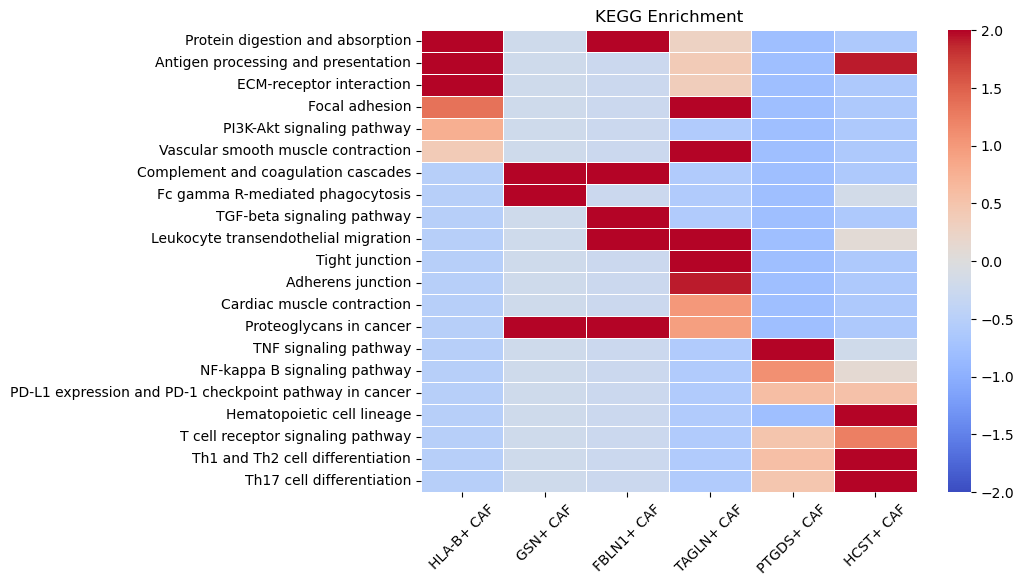

In [76]:
import seaborn as sns

plot_df.columns = ["HLA-B+ CAF", "GSN+ CAF", "FBLN1+ CAF", "TAGLN+ CAF", "PTGDS+ CAF", "HCST+ CAF"]
plt.figure(figsize=(8, 6))
sns.heatmap(plot_df, cmap="coolwarm", center=0, vmin=-2, vmax=2, linewidth=0.5)
plt.xticks(rotation=45)
plt.title("KEGG Enrichment")
plt.show()